In this Notebook we will be building a model to predict Flight Price. In doing so, we would be going through the life cycle of a data science project. Data is given from Kaggle.

Here's the link to the dataset: https://www.kaggle.com/nikhilmittal/flight-fare-prediction-mh


So, Let's begin...

1. Import Libraries
2. Load Train Data
3. Basic EDA
4. Data_Cleaning & Feature Extraction
5. Handling Categorical Data
    * Airline
    * Source & Destination
    * Route & Additional_Info
    * Total_Stops
6. Load Test data
7. Preprocessing
8. Feature Selection
9. Feature Importance using ExtraTreeRegressor
10. Model Building
    * RandomForestRegressor

In [1]:
#to work with excelfile run below command
!pip install openpyxl

     |████████████████████████████████| 243 kB 1.3 MB/s eta 0:00:01
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8913 sha256=e21f6b850660e7f9c3b0eb503a38ea0bf87ac02f2690167f5721319554a19198
  Stored in directory: /root/.cache/pip/wheels/e2/bd/55/048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built et-xmlfile


# Import Libraries

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flight-fare-prediction-mh/Data_Train.xlsx
/kaggle/input/flight-fare-prediction-mh/Sample_submission.xlsx
/kaggle/input/flight-fare-prediction-mh/Test_set.xlsx


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Load Train Data

In [4]:
train_data = pd.read_excel(r'../input/flight-fare-prediction-mh/Data_Train.xlsx')
# to see maximum data values
pd.set_option('display.max_columns', None)
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [5]:
# get insights from data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


As we can see that our data has many independent features of object type and one dependent feature i.e. Price of integer type ,which we will be predicting.

We need to convert the data to numeric values to build the model.

In [6]:
train_data.Duration.value_counts()

2h 50m     550
1h 30m     386
2h 45m     337
2h 55m     337
2h 35m     329
          ... 
47h 40m      1
4h 10m       1
19h 50m      1
13h 35m      1
33h 45m      1
Name: Duration, Length: 368, dtype: int64

In [7]:
#Let's have a look at the shape of our data
train_data.shape

(10683, 11)

In [8]:
#Drop na values
train_data.dropna(inplace = True)

In [9]:
#Check the shape again
train_data.shape

(10682, 11)

As we can see there is just one na value

In [10]:
#Let's see if there are any null values
train_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

# EDA

We will be converting the data, so it will be suitable to build the model.
Convert the object date to datetime. and separate it intodaya and month.

In [11]:
import datetime as dt
train_data['Journey_day'] = pd.to_datetime(train_data.Date_of_Journey, format='%d/%m/%Y').dt.day
train_data['Journey_month'] = pd.to_datetime(train_data.Date_of_Journey, format='%d/%m/%Y').dt.month

In [12]:
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


In [13]:
#Now drop the column
train_data.drop(['Date_of_Journey'], axis = 1, inplace = True)

In [14]:
#Convert and extract hour, minute from departure time, then drop the column
train_data['Dep_hour'] = pd.to_datetime(train_data.Dep_Time).dt.hour
train_data['Dep_minute'] = pd.to_datetime(train_data.Dep_Time).dt.minute
train_data.drop(['Dep_Time'], axis = 1, inplace = True)
train_data.head()

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,13:15,7h 25m,2 stops,No info,7662,1,5,5,50
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,04:25 10 Jun,19h,2 stops,No info,13882,9,6,9,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,23:30,5h 25m,1 stop,No info,6218,12,5,18,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,21:35,4h 45m,1 stop,No info,13302,1,3,16,50


In [15]:
#Convert and extract hour, minute from arrival time, then drop the column
train_data['Arrival_hour'] = pd.to_datetime(train_data.Arrival_Time).dt.hour
train_data['Arrival_minute'] = pd.to_datetime(train_data.Arrival_Time).dt.minute
train_data.drop(['Arrival_Time'], axis = 1, inplace = True)
train_data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


In [16]:
# Time taken by plane to reach destination is called Duration
# It is the differnce betwwen Departure Time and Arrival time

# Assigning and converting Duration column into list
duration = list(train_data["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration

In [17]:
#Create new columns and store the values
train_data['Duration_hours'] = duration_hours
train_data['Duration_mins'] = duration_mins

In [18]:
#Drop the column
train_data.drop(['Duration'], axis = 1, inplace = True)

In [19]:
train_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


# Handling Categorical Values

We will be converting reamaning objects to numeric values

In [20]:
train_data.Airline.value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

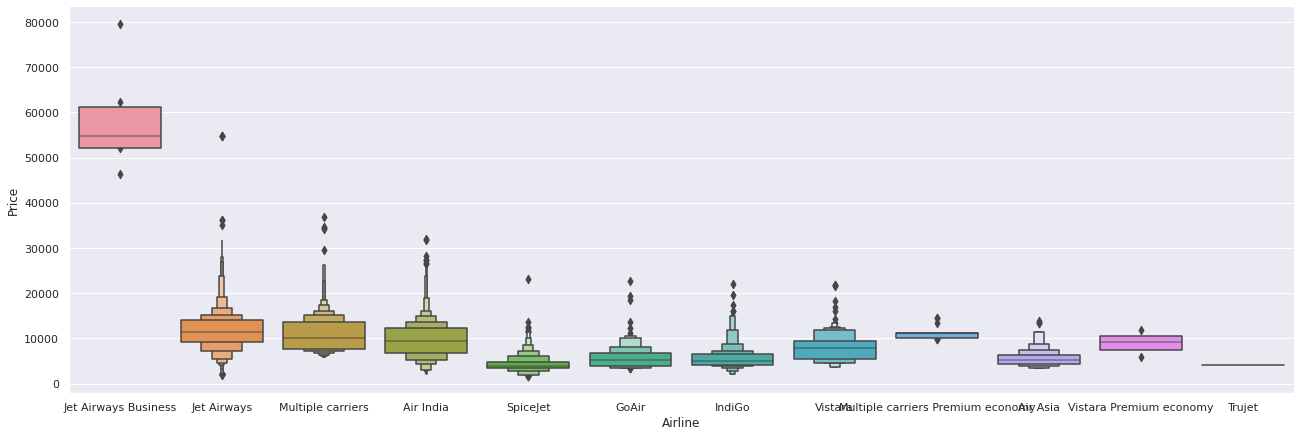

In [21]:
#Let's visualize the price of all airlines
sns.catplot(y = 'Price', x = 'Airline', data = train_data.sort_values('Price', ascending = False), kind = 'boxen', height = 6, aspect = 3)

As we can see jet airways has high prices, rest are quiet similar in price

As Airline, Source, Destination are  Nominal Categorical data we will perform OneHotEncoding

In [22]:
Airline = train_data[["Airline"]]

Airline = pd.get_dummies(Airline, drop_first= True)

Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


In [23]:
train_data['Source'].value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

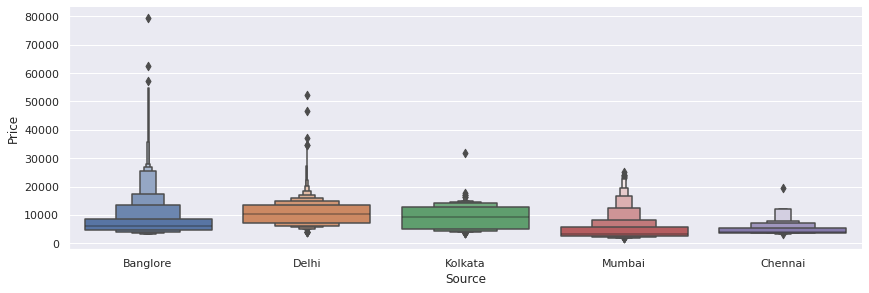

In [24]:
#Visualize the prices at the source 
sns.catplot(y = 'Price', x = 'Source', data = train_data.sort_values('Price', ascending = False), kind = 'boxen', height = 4, aspect = 3)
plt.show()

In [25]:
Source = train_data[['Source']]
Source = pd.get_dummies(Source, drop_first = True)
Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [26]:
train_data['Destination'].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [27]:
Destination = train_data[['Destination']]
Destination = pd.get_dummies(Destination, drop_first = True)
Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [28]:
train_data['Route']

0                    BLR → DEL
1        CCU → IXR → BBI → BLR
2        DEL → LKO → BOM → COK
3              CCU → NAG → BLR
4              BLR → NAG → DEL
                 ...          
10678                CCU → BLR
10679                CCU → BLR
10680                BLR → DEL
10681                BLR → DEL
10682    DEL → GOI → BOM → COK
Name: Route, Length: 10682, dtype: object

In [29]:

# Additional_Info contains almost 80% no_info
# Route and Total_Stops are related to each other

train_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

In [30]:
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,non-stop,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2 stops,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2 stops,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1 stop,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1 stop,13302,1,3,16,50,21,35,4,45


In [31]:
train_data['Total_Stops'].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [32]:
# As this is case of Ordinal Categorical type we perform LabelEncoder
# Here Values are assigned with corresponding keys

train_data.replace({'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4}, inplace = True)

In [33]:
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1,13302,1,3,16,50,21,35,4,45


In [34]:
#combine all data
data_train = pd.concat([train_data, Airline, Source, Destination], axis = 1)

In [35]:
data_train.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,IndiGo,Banglore,New Delhi,1,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [36]:
data_train.drop(['Airline','Source', 'Destination'], axis = 1, inplace = True)
data_train.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [37]:
data_train.shape

(10682, 30)

# Load Test Data

Load the test data and perform all the preprocessing steps we did for train data

In [38]:
test_data = pd.read_excel(r'../input/flight-fare-prediction-mh/Test_set.xlsx')
test_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


# Preprocessing

In [39]:
print('Test data info:')
print('_' * 80)
print(test_data.info())

print('\n \n Null values:')
print('_' * 80)
test_data.dropna(inplace = True)
print(test_data.isnull().sum())

Test data info:
________________________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB
None

 
 Null values:
________________________________________________________________________________
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_T

# EDA of Test Data

In [40]:
#Date_of_Journey
test_data['Journey_day'] = pd.to_datetime(test_data.Date_of_Journey,format = '%d/%m/%Y').dt.day
test_data['Journey_month'] = pd.to_datetime(test_data.Date_of_Journey, format = '%d/%m/%Y').dt.month
test_data.drop(['Date_of_Journey'], axis = 1,inplace = True)

# Dep_Time
test_data["Dep_hour"] = pd.to_datetime(test_data["Dep_Time"]).dt.hour
test_data["Dep_min"] = pd.to_datetime(test_data["Dep_Time"]).dt.minute
test_data.drop(["Dep_Time"], axis = 1, inplace = True)

# Arrival_Time
test_data["Arrival_hour"] = pd.to_datetime(test_data.Arrival_Time).dt.hour
test_data["Arrival_min"] = pd.to_datetime(test_data.Arrival_Time).dt.minute
test_data.drop(["Arrival_Time"], axis = 1, inplace = True)

In [41]:
# Duration
Duration = list(test_data['Duration'])

for i in range(len(Duration)):
    if len(Duration[i].split()) != 2:
        if 'h' in Duration[i]:
            Duration[i] = Duration[i].strip() + ' 0m'
        else:
            Duration[i] = '0h ' + Duration[i]
        
Duration_hour = []
Duration_mins = []
for i in range(len(Duration)):
    Duration_hour.append(int(Duration[i].split(sep = 'h')[0]))
    Duration_mins.append(int(Duration[i].split(sep = 'm')[0].split()[-1]))

test_data['Duration_hours'] = Duration_hour
test_data['Duration_minutes'] = Duration_mins
test_data.drop(['Duration'], axis = 1, inplace = True)

In [42]:
# Categorical data

print("Airline")
print("-"*75)
print(test_data["Airline"].value_counts())
Airline = pd.get_dummies(test_data["Airline"], drop_first= True)

print()

print("Source")
print("-"*75)
print(test_data["Source"].value_counts())
Source = pd.get_dummies(test_data["Source"], drop_first= True)

print()

print("Destination")
print("-"*75)
print(test_data["Destination"].value_counts())
Destination = pd.get_dummies(test_data["Destination"], drop_first = True)

Airline
---------------------------------------------------------------------------
Jet Airways                          897
IndiGo                               511
Air India                            440
Multiple carriers                    347
SpiceJet                             208
Vistara                              129
Air Asia                              86
GoAir                                 46
Multiple carriers Premium economy      3
Vistara Premium economy                2
Jet Airways Business                   2
Name: Airline, dtype: int64

Source
---------------------------------------------------------------------------
Delhi       1145
Kolkata      710
Banglore     555
Mumbai       186
Chennai       75
Name: Source, dtype: int64

Destination
---------------------------------------------------------------------------
Cochin       1145
Banglore      710
Delhi         317
New Delhi     238
Hyderabad     186
Kolkata        75
Name: Destination, dtype: int64


In [43]:
# Additional_Info contains almost 80% no_info
# Route and Total_Stops are related to each other
test_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

In [44]:
# Replacing Total_Stops
test_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

In [77]:
#Combine all data:  test_data + Airline + Source + Destination
data_test = pd.concat([test_data, Airline, Source, Destination], axis = 1)

data_test.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

print("Shape of test data : ", data_test.shape)

Shape of test data :  (2671, 28)


In [46]:
data_test.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_minutes,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,1,6,6,17,30,4,25,10,55,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,1,12,5,6,20,10,20,4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,21,5,19,15,19,0,23,45,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,21,5,8,0,21,0,13,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
4,0,24,6,23,55,2,45,2,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


# Feature Selection

Finding out the best feature which will contribute and have good relation with target variable. Following are some of the feature selection methods,

**heatmap**

**feature_importance_**

**SelectKBest**

In [47]:
data_train.shape

(10682, 30)

Separate independent and dependent data

In [48]:
#Independent data
x = data_train.drop(['Price'], axis = 1)
x.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [49]:
#Dependent data
y = data_train['Price']
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

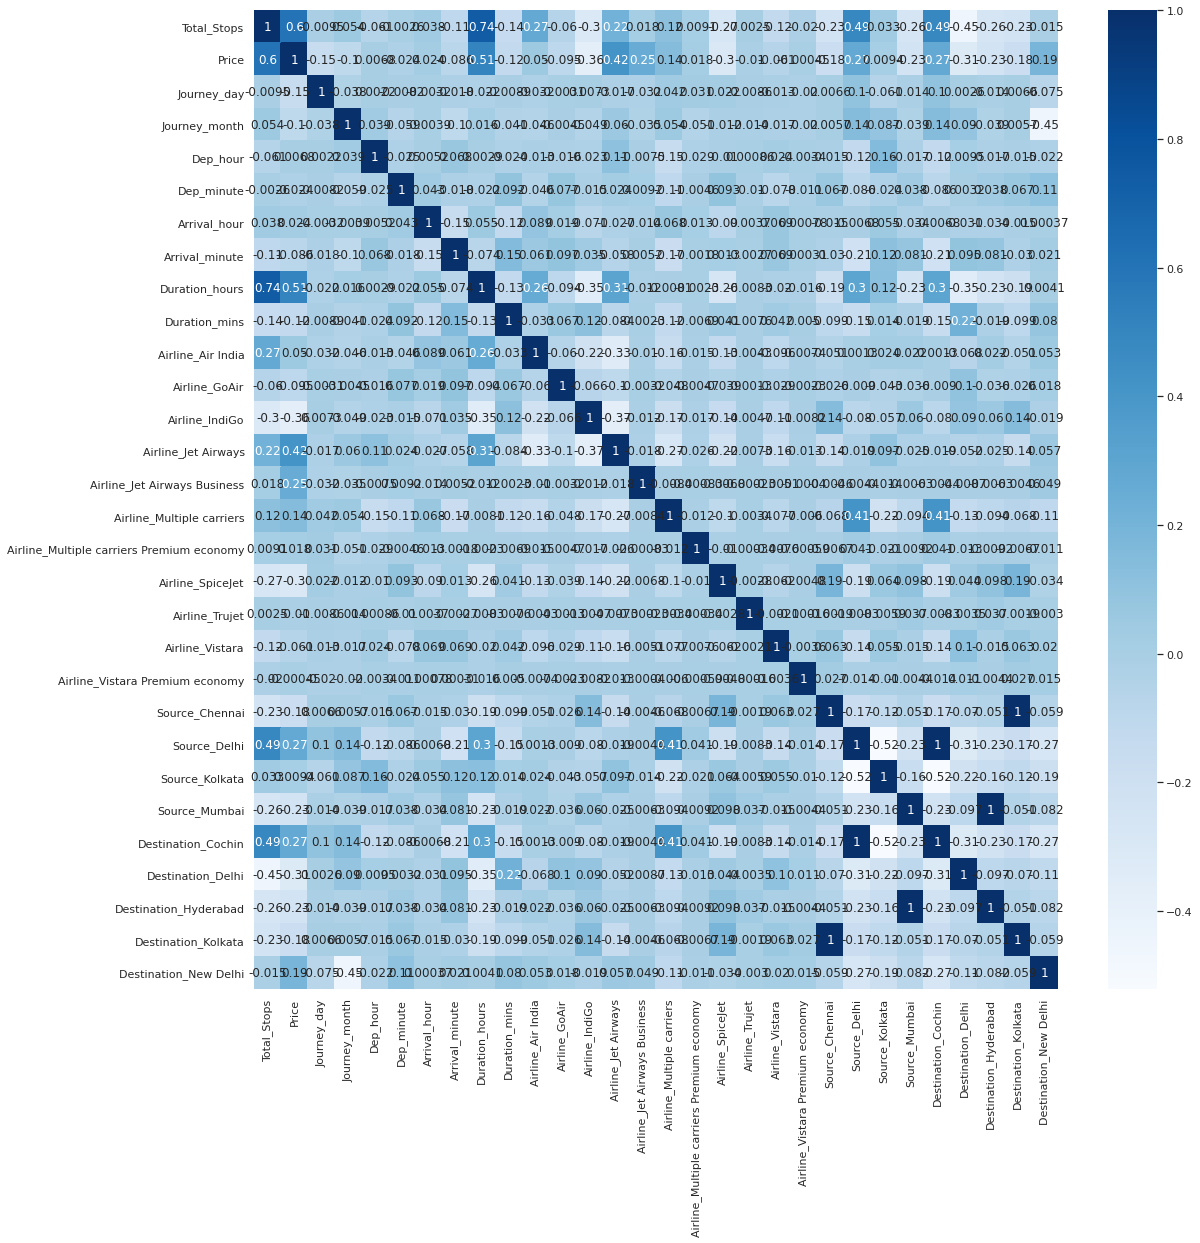

In [50]:
# Finds correlation between Independent and dependent attributes

plt.figure(figsize = (18,18))
sns.heatmap(data_train.corr(), annot = True, cmap = 'Blues')
plt.show()

In [51]:
# Important feature using ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor()
model.fit(x, y)

ExtraTreesRegressor()

In [52]:
print(model.feature_importances_)

[2.24900893e-01 1.43233374e-01 5.34977972e-02 2.40734939e-02
 2.17116925e-02 2.76685550e-02 1.94233632e-02 1.29475937e-01
 1.74554256e-02 9.36626831e-03 2.01271378e-03 1.70806092e-02
 1.38851914e-01 6.77644259e-02 1.82679172e-02 8.29864301e-04
 2.94297324e-03 8.94562194e-05 4.89288275e-03 8.55886097e-05
 5.35038732e-04 1.13454325e-02 3.14819012e-03 6.71449608e-03
 1.09575373e-02 1.21255462e-02 6.30184853e-03 4.69664851e-04
 2.47770998e-02]


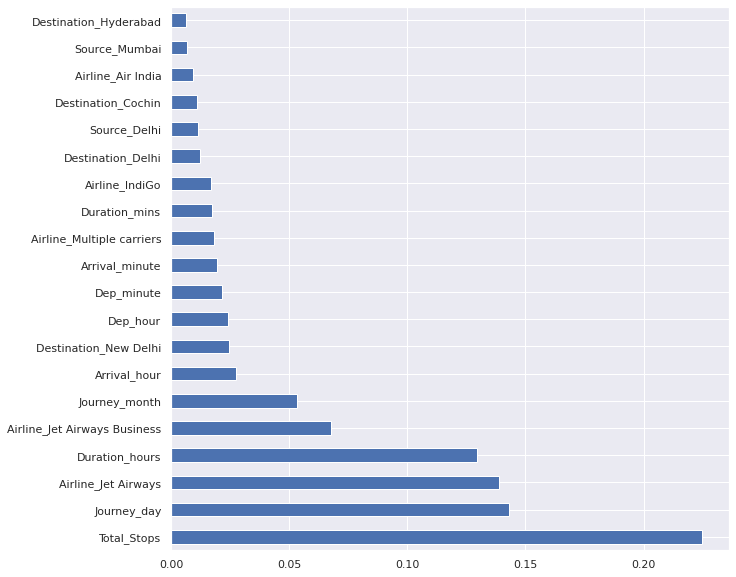

In [53]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (10, 10))
feat_imp = pd.Series(model.feature_importances_, index = x.columns)
feat_imp.nlargest(20).plot(kind = 'barh')
plt.show()

# Fitting model using Random Forest


Split the data using train_test_split

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

Create model and fit the data

In [55]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train, y_train)

RandomForestRegressor()

Predict on x_test data 

In [56]:
y_pred = reg_rf.predict(X_test)

Check the score

In [57]:
reg_rf.score(X_train, y_train)

0.9533012313661225

In [58]:
reg_rf.score(X_test, y_test)

0.7985799068266566

Plot the error difference 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


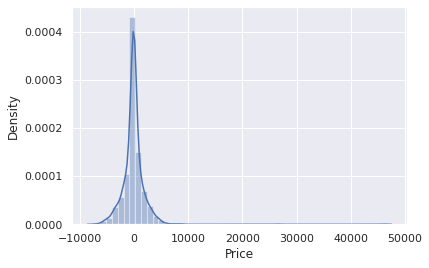

In [59]:
sns.distplot(y_test-y_pred)
plt.show()

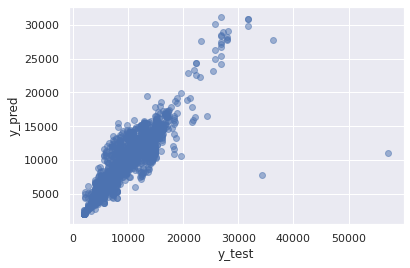

In [60]:
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

Get the MAE, MSE, and RSME score

In [61]:
from sklearn import metrics

In [62]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 1174.3148821382822
MSE: 4343031.393821545
RMSE: 2083.994096397959


In [63]:
metrics.r2_score(y_test, y_pred)

0.7985799068266566

# Hyperparameter Tuning

* Choose following method for hyperparameter tuning
    * RandomizedSearchCV --> Fast
    * GridSearchCV
* Assign hyperparameters in form of dictionery
* Fit the model
* Check best paramters and best score

In [64]:
from sklearn.model_selection import RandomizedSearchCV

In [65]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1200, num = 12 )]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num= 6)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10] 

In [66]:
#create random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [67]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = reg_rf, param_distributions = random_grid, scoring = 'neg_mean_squared_error',n_iter = 10, cv = 5, verbose = 2, random_state = 42, n_jobs = 1)

Fit the model

In [68]:
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=875; total time=   4.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=875; total time=   4.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=875; total time=   4.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=875; total time=   4.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=875; total time=   4.4s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1091; total time=   6.7s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1091; total time=   6.7s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [10, 118, 226, 334, 442,
                                                         550, 659, 767, 875,
                                                         983, 1091, 1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

Find the best params

In [69]:
rf_random.best_params_

{'n_estimators': 659,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

Get the predictions on test data 

In [70]:
predictions = rf_random.predict(X_test)

Plot the error difference

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


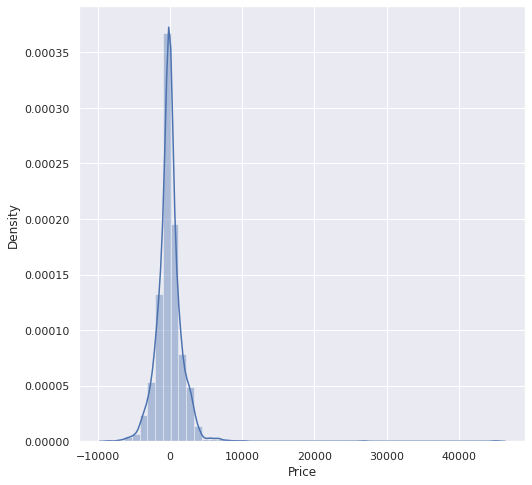

In [71]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-predictions)
plt.show()

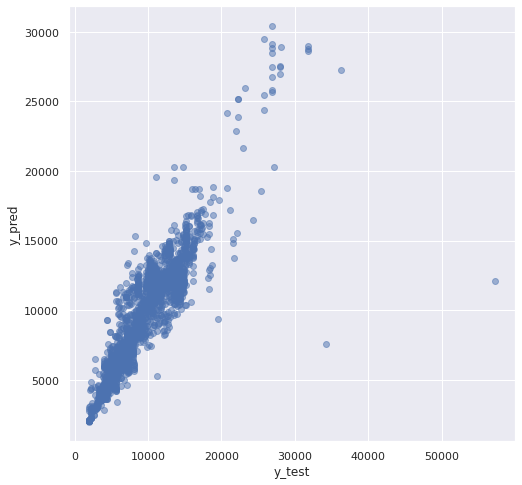

In [72]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, predictions, alpha = 0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

Get the MAE, MSE, and RSME score

In [73]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 1163.3682255597694
MSE: 4032126.8336866233
RMSE: 2008.015645777349


# Save the model to reuse it again

In [74]:
import pickle
# open a file, where you ant to store the data
file = open('flight_rf.pkl', 'wb')

# dump information to that file
pickle.dump(rf_random, file)

In [78]:
flight_model = open('flight_rf.pkl','rb')
forest = pickle.load(flight_model)

In [ ]:
y_prediction = forest.predict(X_test)

In [76]:
metrics.r2_score(y_test, y_prediction)

NameError: name 'y_prediction' is not defined

In [ ]:
 !pip freeze > '../working/flight_requirements.txt'